In [1]:
#!/usr/bin/env python
"""

Original network from  BRUNEL, Nicolas et WANG, Xiao-Jing. Effects of neuromodulation in a cortical network model of
object working memory dominated by recurrent inhibition. Journal of computational neuroscience, 2001, vol. 11, no 1,
p. 63-85.
"""
from __future__ import print_function, division, absolute_import
# noinspection PyUnresolvedReferences
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

# noinspection PyUnresolvedReferences
import os

from brian2.units.constants import zero_celsius, gas_constant as R, faraday_constant as F
from brian2 import *
from brian2tools import brian_plot, plot_state
import brian2.numpy_ as np

logger = logging.getLogger("tau")
# logger.addHandler(handler)

################################################################################
# Settings
################################################################################

celsius_temp = 37  # Temperature
T = celsius_temp * kelvin + zero_celsius
rt_f = R * T / F

start_time = time.time()
sum_time = 0
# seed(11999)  # to get identical figures for repeated runs
start_scope()

################################################################################
# Model parameters
################################################################################
# Network
N = 1  # Number of total neurons

# Neuron
V_thr = -50. * mV  # Firing threshold
V_reset = -70. * mV  # Reset potential
C_m = 0.550 * nF  # Membrane capacitance (excitatory population)
tau_r = 2. * ms  # Refractory period (excitatory population)

# Size
L = 7.5 * um  # Length
a = L/2
volume = 4.0 / 3.0 * pi * (L / 2) * (a ** 2)  # volume oblate spheroid

# Leak
E_leak = -70. * mV  # Leak reversal potential
g_l = 20. * nS  # Leak conductance (excitatory population)

# GABAergic (inhibitory)
g_GABA_max = 5 * nS
tau_GABA = 10. * ms
E_Cl_0 = -88. * mV  # Reversal potential for Chloride
E_HCO3 = -10 * mV  # Reversal potential for Bicarbonate
pcl = 0.8  # Permeability proportion of Chloride through GABAA
phco3 = 1 - pcl  # Permeability proportion of Bicarbonate through GABAA
C_Cl_in = 5 * mM  # Internal chloride concentration (indirectly varied through d_ECl/dt)
C_Cl_out = C_Cl_in / exp(E_Cl_0 * (1 / rt_f))  # External chloride concentration (constant)
ecl_alpha = rt_f / (F * volume * C_Cl_out)
ecl_beta = 1 / rt_f
E_GABA_0 = pcl * E_Cl_0 + phco3 * E_HCO3  # Reversal potential for GABAA (Ohmic formulation using Cl and HCO3
#  permeabilities)
logger.debug("EGABA = {:.2f}".format(E_GABA_0 / mV))

tau_KCC2_0 = 40 * second

################################################################################
# Model definition
################################################################################
dE_Cl_influx = 'ecl_alpha * exp( -(ecl_beta * E_Cl)) * I_Cl'
dE_Cl_efflux = '(E_Cl - E_Cl_0)/tau_KCC2'
neuron_eqs = f'''
    in_eff: 1
    out_eff: 1
    tau_KCC2: second

    E_GABA = pcl * E_Cl + phco3 * E_HCO3 : volt       
    I_GABA = g_GABA * (v - E_GABA) : amp
    I_Cl = pcl*g_GABA * (v - E_Cl) : amp

    dv / dt = (- g_l * (v - E_leak) - I_GABA) / C_m : volt
    dE_Cl / dt = in_eff*{dE_Cl_influx} - out_eff*{dE_Cl_efflux} : volt
    dg_GABA / dt = - g_GABA / tau_GABA : siemens

'''
# noinspection PyTypeChecker
neurons = NeuronGroup(N, neuron_eqs, threshold='v > V_thr', reset='v = V_reset', refractory='tau_r',
                      method='euler')

# ##############################################################################
# # Initialisation
# ##############################################################################
neurons.v = E_leak
neurons.in_eff = 1
neurons.out_eff = 0
neurons.tau_KCC2 = tau_KCC2_0
neurons.E_Cl = E_Cl_0
neurons.g_GABA = 0 * nS

# external
rate_ext = 5 * Hz
num_inputs = 1  # int(200 * 0.02)
P = PoissonInput(neurons, 'g_GABA', num_inputs, rate_ext, 'g_GABA_max')

# ##############################################################################
# # Monitors
# ##############################################################################
v_vars = ['E_GABA', 'E_Cl', 'v']
i_vars = ['I_GABA', 'I_Cl']
g_state_mon = StateMonitor(neurons, ['g_GABA'], record=True)
v_state_mon = StateMonitor(neurons, v_vars, record=True)
i_state_mon = StateMonitor(neurons, i_vars, record=True)

setup_time = time.time()
setup_dt = setup_time - start_time
sum_time += setup_dt
logger.info('took {:.2f}s to setup'.format(setup_dt))

INFO:tau:took 0.02s to setup


In [2]:
from tqdm import tqdm
logger.info("running")
single_run = 30 * second
total_duration = 0

pbar = tqdm(total=float("inf"), unit="s")

logging.getLogger("root").setLevel(logging.WARNING)

while True:
    run(single_run, report=None)
    total_duration += single_run
    
    pbar.set_description_str(f"E_Cl = {v_state_mon.E_Cl[0,-1]/mV:.3f} mV")
    pbar.update(single_run/second)

    if 0.01 * mV > v_state_mon.E_Cl[0,-1] - \
                    v_state_mon.E_Cl[0,-int(single_run/defaultclock.dt)]:
        break


INFO:tau:running
0s [00:00, ?s/s]WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]
E_Cl = -69.459 mV: 270.0s [00:40,  6.79s/s]

In [3]:
v_state_mon.t[-1]/second

269.9999

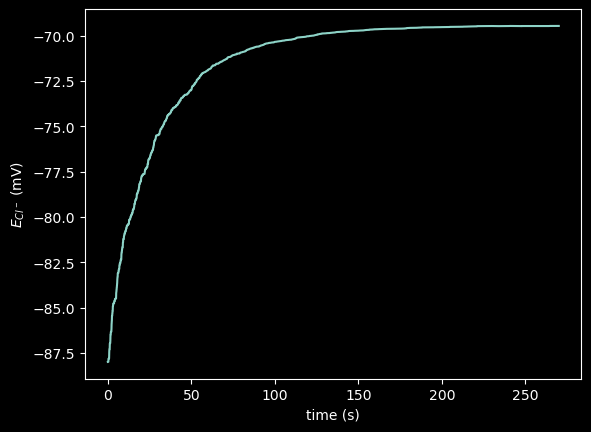

In [4]:
plot_state(v_state_mon.t, v_state_mon.E_Cl.T, var_name='$E_{Cl^-}$', time_unit=second)
        
logger.info(f"run for {v_state_mon.t[-1]/second} seconds")
E_Cl_steady = v_state_mon.E_Cl[0, -1]
E_Cl_steady_0 = E_Cl_steady

In [5]:
E_Cl_tau = (E_Cl_steady - E_Cl_0)*(1-1/np.e) + E_Cl_0    # value at 1-1/e of step function (E0 to Esteady)
tau_index = argmin(np.abs(E_Cl_tau-v_state_mon.E_Cl))
duration_tau = v_state_mon.t[tau_index]

In [6]:
print(E_Cl_tau)
print(duration_tau)


-76.27984986 mV
27.0365 s


In [7]:
total_i_cl = np.sum(i_state_mon.I_Cl[:tau_index]) * defaultclock.dt / duration_tau
initial_size = i_state_mon.I_Cl[0].size
logger.info(f"it took {duration_tau / second}s for ECl to go from "
            f"{E_Cl_0 / mV}mV to {E_Cl_tau / mV}mV through an ICl of {total_i_cl / nA} nA")
decl_in = ecl_alpha * exp(-(ecl_beta * E_Cl_steady)) * total_i_cl * duration_tau
tau = (E_Cl_tau - E_Cl_0) / decl_in * duration_tau
logger.info(f"required compensatory KCC2 tau={tau / second} seconds")
neurons.in_eff = 0
neurons.out_eff = 1
neurons.tau_KCC2 = tau

In [8]:
run(total_duration, report='text')
total_i_cl = np.sum(i_state_mon.I_Cl[0][initial_size:]) * defaultclock.dt / total_duration
logger.info(f"total_i_cl after= {total_i_cl / nA} nA")
p2_size = i_state_mon.I_Cl[0].size
logger.info(f"ECl after only extrusion = {v_state_mon.E_Cl[0,-1]/mV:.3f} mV")


logger.info(f"activating both intrusion and extrusion, resetting ECl to {E_Cl_0}")
neurons.in_eff = 1
neurons.out_eff = 1
neurons.E_Cl = E_Cl_0

Starting simulation at t=270. s for a duration of 270. s
52.8952 s (19%) simulated in 10s, estimated 41s remaining.
94.5326 s (35%) simulated in 20s, estimated 37s remaining.
161.3614 s (59%) simulated in 30s, estimated 20s remaining.
229.7959 s (85%) simulated in 40s, estimated 7s remaining.
270. s (100%) simulated in 45s


In [9]:
run(total_duration, report='text')

total_i_cl = np.sum(i_state_mon.I_Cl[0][p2_size:]) * defaultclock.dt / total_duration
E_Cl_steady = v_state_mon.E_Cl[0, -1]
logger.info(f"it took {total_duration / second}s for ECl to go from "
            f"{E_Cl_0 / mV}mV to {E_Cl_steady / mV}mV through an ICl of {total_i_cl / nA} nA")
logger.info(f"total_i_cl after= {total_i_cl / nA} nA")

run_time = time.time()
run_dt = run_time - setup_time
sum_time = run_time - start_time
logger.info('took {:.2f}s to run (total time = {:.2f}s)'.format(run_dt, sum_time))

Starting simulation at t=0.54 ks for a duration of 270. s
64.3462 s (23%) simulated in 10s, estimated 32s remaining.
131.544 s (48%) simulated in 20s, estimated 21s remaining.
197.0464 s (72%) simulated in 30s, estimated 11s remaining.
264.9984 s (98%) simulated in 40s, estimated 1s remaining.
270. s (100%) simulated in 40s


<Axes: xlabel='time (s)', ylabel='$E_{Cl^-}$ (mV)'>

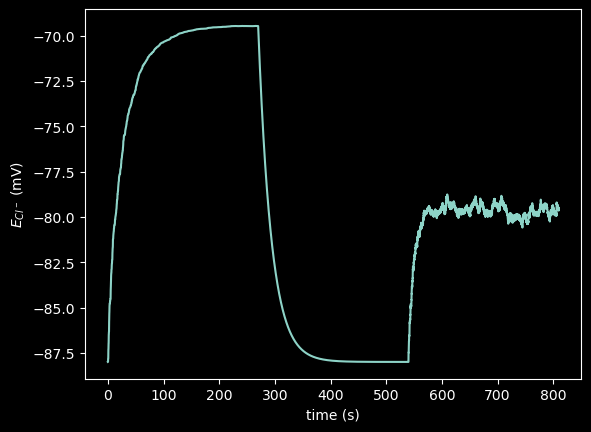

In [10]:
time_unit = second
plot_state(v_state_mon.t, v_state_mon.E_Cl.T, time_unit=second, var_name='$E_{Cl^-}$')

<Axes: xlabel='time (ms)', ylabel='g_GABA (pS)'>

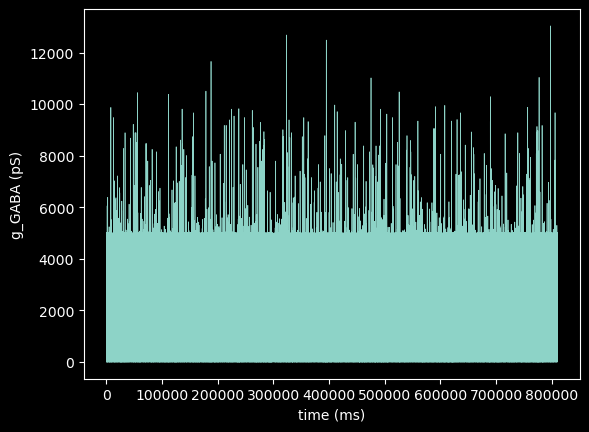

In [15]:
brian_plot(g_state_mon, lw=0.5)

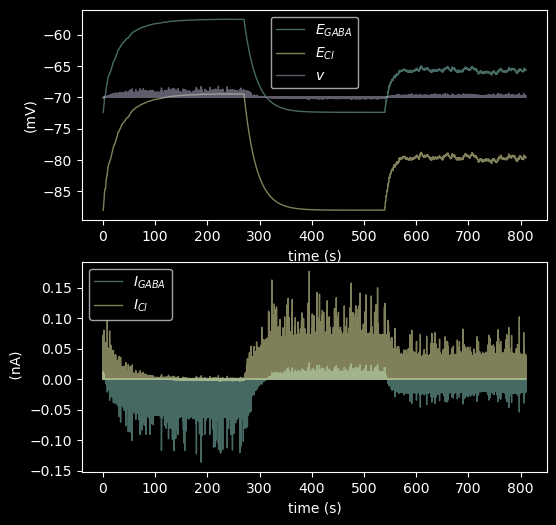

In [16]:
fix, ax = plt.subplots(2, 1, figsize=(6,6))
time_unit=second
for v_var in v_vars:
    plot_state(v_state_mon.t, getattr(v_state_mon, v_var).T, axes=ax[0], var_name='', var_unit=mV, time_unit=time_unit,
               lw=1, alpha=0.5)
ax_to_annotate: Axes = ax[1]
ax_to_annotate.annotate(f"$\tau={tau / second} s$", xy=(initial_size, E_Cl_steady_0 / mV))

for i_var in i_vars:
    plot_state(i_state_mon.t, getattr(i_state_mon, i_var).T, axes=ax[1], var_name='', var_unit=nA, time_unit=time_unit,
               lw=1,
               alpha=0.5)

ax[0].set_ylabel('(mV)')
v_vars_leg = []
for v_var in v_vars:
    tmp = v_var.replace("_", "_{")
    tmp = tmp + '}' if '{' in tmp else tmp
    v_vars_leg.append(f"${tmp}$")
i_vars_leg = []
for i_var in i_vars:
    tmp = i_var.replace("_", "_{")
    tmp = tmp + '}' if '{' in tmp else tmp
    i_vars_leg.append(f"${tmp}$")
ax[0].legend(v_vars_leg)
ax[1].legend(i_vars_leg)

total_i = np.sum(i_state_mon.I_Cl) / nA

logger.info(f"total_i = {total_i} nA")

if matplotlib.get_backend().lower() not in ['agg', 'pdf']:
    show()